In [12]:
from functools import partial
import json
from pathlib import Path
from numpy import ndarray
from pytorch_autoencoders.config import Config
from pytorch_autoencoders.data import Dsprites
from pytorch_autoencoders.models import gamma_vae, conv_vae
from pytorch_autoencoders import inference_helper, train_helper
import torch
from torch.optim import Adam

import numpy as np
from matplotlib import pyplot as plt
import PIL.Image as Image

from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm

import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

from torchvision import transforms
from torchvision import datasets
import time

In [2]:
from radioreader import *
from methods import *
from kittler import kittler_float

In [3]:
directory = 'unlrg'
ext = 'fits'
names = glob.glob('{0}/*.{1}*'.format(directory, ext))
images = []
for n in tqdm(range(len(names))):
    im = readImg(names[n], normalize=True, sz=128)
    k = kittler_float(im, copy=False)
    images.append( np.expand_dims(k, axis=0) )
    del im
    del k
print("Number of images", len(images))


Number of images 14245


In [4]:
class UNLRG(data.Dataset):
    def __init__(self, images, transform=None):
        self.data = images
        self.data_len = len(self.data)
        if(transform == None):
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(180),
#                 transforms.RandomResizedCrop((128,128),(.5,1)),
                transforms.ToTensor()])
        else : self.transform = transform

#     def __load_data
            
    def __getitem__(self, index):
        index = index % self.data_len
        np_arr = self.data[index, :]
        ## reshape np_arr to 28x28
        np_arr = np_arr.reshape(128, 128)

        ## convert to PIL-image
        img = Image.fromarray((np_arr*255).astype('uint8'))

        #apply the transformations and return tensors
        return self.transform(img)
    def __len__(self):
        return self.data_len * 10
    def __repr__(self) -> str:
        return 'unLRG dataset'

In [5]:
images = np.array(images)
dataset = UNLRG(images)

In [6]:
np.max(images)

0.9996233380807099

In [7]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d( 1,  8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d( 8,  8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d( 8, 16, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 2, 1, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d( 8,  8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d( 8,  1, 3, 2, 1, 1),
#             nn.ReLU()
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decode(x)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decode  = self.decoder(encoded)
        return torch.sigmoid(decode)

In [8]:
data_loader = data.DataLoader(dataset, batch_size=64, shuffle=False)

In [9]:
device = 'cuda'

cae = CAE().to(device)
optimizer = Adam(cae.parameters(), lr=0.001)
loss_fnc = nn.BCELoss(reduction='sum').to(device)

In [16]:
def train_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    s = ''
    for batch_idx, data in enumerate(data_loader):
        data = data.to(device)
        #Forward Pass
        optimizer.zero_grad()
        output = model(data)
        
        # BCE Loss
        loss = loss_fnc(output, data)
        
        #Backpropagation
        loss.backward()
        optimizer.step()
        s = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item())
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s

In [17]:
for epoch in range(1, 101):
    start = time.time()
    s = train_step(cae, 'cuda' ,data_loader, optimizer, epoch)
    t = time.time() - start
    sys.stdout.write('{0}\tTime {1:.2f}s\n'.format(s, t))

Train Epoch: 1 [111250/142450 (100%)]	Loss: 5346.309570	Time 79.47s
Train Epoch: 2 [111250/142450 (100%)]	Loss: 4910.729980	Time 79.57s
Train Epoch: 3 [111250/142450 (100%)]	Loss: 4728.229492	Time 79.27s
Train Epoch: 4 [111250/142450 (100%)]	Loss: 4651.133301	Time 79.38s
Train Epoch: 5 [111250/142450 (100%)]	Loss: 4579.273438	Time 79.38s
Train Epoch: 6 [111250/142450 (100%)]	Loss: 4518.916504	Time 79.26s
Train Epoch: 7 [111250/142450 (100%)]	Loss: 4472.480469	Time 79.55s
Train Epoch: 8 [111250/142450 (100%)]	Loss: 4485.914062	Time 79.21s
Train Epoch: 9 [111250/142450 (100%)]	Loss: 4457.556152	Time 79.36s
Train Epoch: 10 [111250/142450 (100%)]	Loss: 4429.944336	Time 79.12s
Train Epoch: 11 [111250/142450 (100%)]	Loss: 4402.909180	Time 79.46s
Train Epoch: 12 [111250/142450 (100%)]	Loss: 4399.395996	Time 79.50s
Train Epoch: 13 [111250/142450 (100%)]	Loss: 4394.670410	Time 79.40s
Train Epoch: 14 [111250/142450 (100%)]	Loss: 4332.974609	Time 79.17s
Train Epoch: 15 [111250/142450 (100%)]	Loss

In [18]:
sample = iter(data_loader).next()

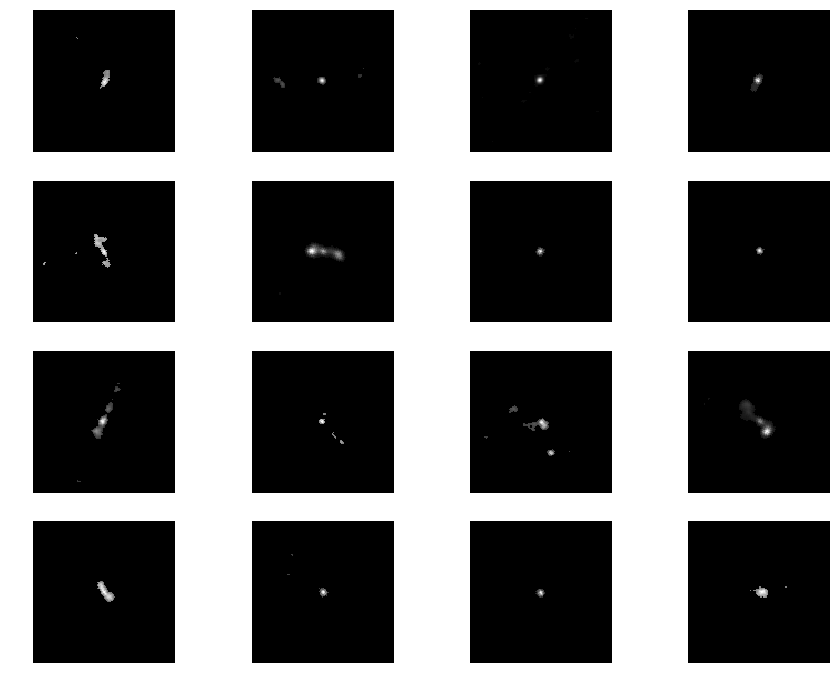

In [19]:
f, ax = plt.subplots(4, 4, figsize=(15, 12))
for i in range(4): 
    for j in range(4):
        ax[i][j].imshow(sample[i*4 + j][0], cmap='gray')
        ax[i][j].axis('off')

In [20]:
with torch.no_grad():
    recon = cae(sample.to(device)).cpu()

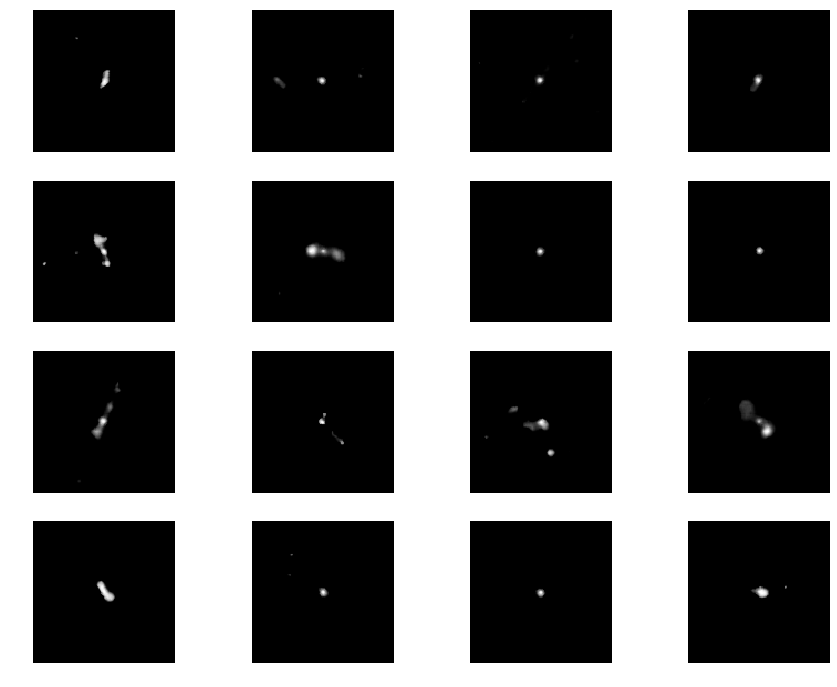

In [21]:
f, ax = plt.subplots(4, 4, figsize=(15, 12))
for i in range(4): 
    for j in range(4):
        ax[i][j].imshow(recon[i*4 + j][0], cmap='gray')
        ax[i][j].axis('off')

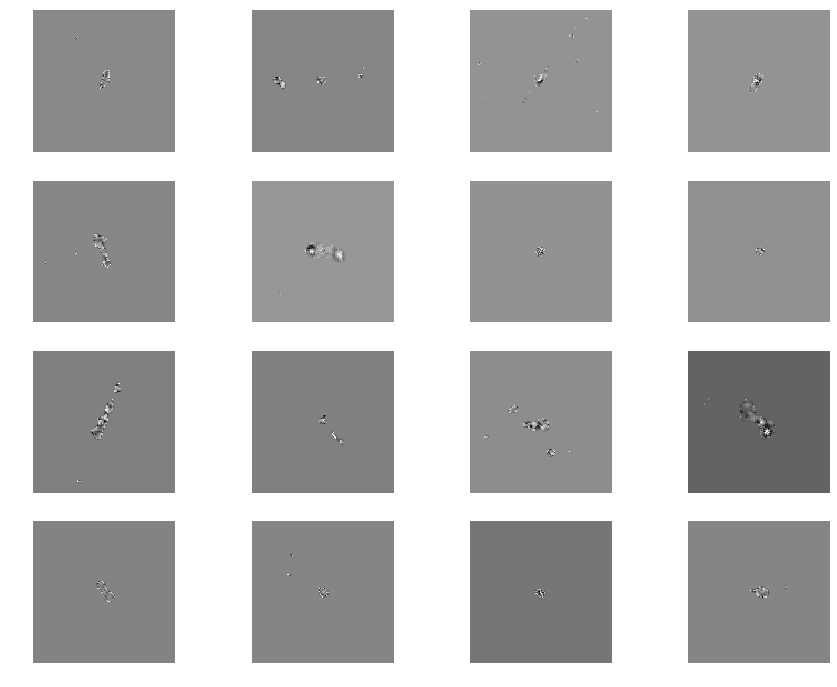

In [22]:
f, ax = plt.subplots(4, 4, figsize=(15, 12))
for i in range(4): 
    for j in range(4):
        o, r = sample[i*4 + j][0], recon[i*4 + j][0] 
        ax[i][j].imshow(o - r, cmap='gray')
        ax[i][j].axis('off')

In [23]:
torch.save(cae, 'cae_model')
# cae = torch.load('cae_model')
# cae.eval()